# Policy Laplace on Spark

Spark implementation of Policy Laplace from [Differentially Private Set Union](https://arxiv.org/abs/2002.09745)

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/opendp/smartnoise-sdk/blob/main/sql/samples/Policy%20Laplace%20on%20Spark.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/opendp/smartnoise-sdk/blob/main/sql/samples/Policy%20Laplace%20on%20Spark.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/opendp/smartnoise-sdk/blob/main/sql/samples/Policy%20Laplace%20on%20Spark.ipynb">
      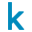
      Run on Kaggle
    </a>
  </td>                                                                                               
</table>

In [ ]:
!pip install smartnoise-sql pyspark --quiet

In [ ]:
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()

In [ ]:
from os import path
if not path.exists('clean_askreddit.csv'):
    if not path.exists('clean_askreddit.csv'):
        !pip install wget
        import wget
        zip_path = 'https://github.com/joshua-oss/differentially-private-set-union/raw/master/data/clean_askreddit.csv.zip'
        wget.download(zip_path)
    import zipfile
    with zipfile.ZipFile('clean_askreddit.csv.zip', 'r') as zip:
        zip.extractall('.')
    

In [ ]:
filepath = "clean_askreddit.csv"
reddit = spark.read.load(filepath, format="csv", sep=",",inferSchema="true", header="true").dropna()

### Prepare Data for Processing

Load the data from file and tokenize.  This code can be any caller-specific tokenization routine, and is independent of differential privacy.  Output RDD should include one list of tokens per row, but can have multiple rows per user, and does not need to be odered in any way.  This stage can be combined with other n_grams (e.g. 2-grams, 3-grams) and persisted to feed to DPSU.

In [ ]:
import nltk

n_grams = 1
distinct = True

def tokenize(user_post):
    user, post = user_post
    tokens = post.split(" ")
    if n_grams > 1:
        tokens = list(nltk.ngrams(tokens, n_grams))
        tokens = ["_".join(g) for g in tokens]
    if distinct:
        tokens = list(set(tokens))
    return (user, tokens)
        
tokenized = reddit.select("author", "clean_text").rdd.map(tokenize).persist()


### Instantiate DPSU Processor

Create the object and pass in the privacy parameters.

In [ ]:
from __future__ import division
from collections import defaultdict
import operator
import copy
import numpy as np
import itertools
from pyspark.rdd import portable_hash

class PolicyLaplace:
    def __init__(self, epsilon, delta, alpha, tokens_per_user, prune_tail_below=None, num_partitions=1):
        Delta_0 = tokens_per_user
        self.Delta_0 = Delta_0 # tokens_per_user
        self.K = prune_tail_below
        self.num_partitions = num_partitions if num_partitions is not None else 1
        self.Delta = 1 / self.num_partitions  # budget per user
        #if self.K == 1:
        #    self.K = None

        l_param = 1 / epsilon
        F_l_rho = lambda t: 1 / t + (1 / epsilon) * np.log(1 / (2 * (1 - (1 - delta) ** (1 / t))))
        l_rho = np.max([F_l_rho(t) for t in range(1, Delta_0 + 1)])
        if self.K is not None:
            l_rho = self.K + (1/epsilon) * np.log(1 / (2 * (1 - (1 - delta) ** (1 / Delta_0))))

        Gamma=l_rho + alpha*l_param
        self.Gamma = Gamma
        self.l_param = l_param
        self.l_rho = l_rho

        print("Params Delta_0={0}, delta={1:.2e}, l_param={2}, l_rho={3}, Gamma={4}".format(Delta_0, delta, l_param, l_rho, Gamma))

    
    def exceeds_threshold(self, val):
        nval = val + np.random.laplace(0, self.l_param)
        if nval > self.l_rho:
            return True
        else:
            return False

    def prune_tail(self, user_tokens_rdd):
        """Prunes the (user, tokens) RDD to eliminate all words that appear
            fewer than prune_tail_below supplied at instantiation time.
        """
        if self.K is None:
            return user_tokens_rdd
        tu = user_tokens_rdd.flatMap(lambda row: [(token, row[0]) for token in row[1]])
        tu = tu.keyBy(lambda row: row[0])

        ut = user_tokens_rdd.flatMap(lambda row: [(token, 1) for token in row[1]])
        wc = ut.reduceByKey(operator.add)
        wc = wc.filter(lambda row: (row[1] >= self.K))

        filtered = wc.keyBy(lambda row: row[0]).join(tu).map(lambda row: row[1][1])
        return filtered.map(lambda row: (row[1], row[0])).groupByKey()


    def reservoir_sample(self, user_tokens_rdd, distinct=True):
        """Takes an RDD with (user, tokens) and combines all tokens from all users,
            then samples uniformly to get at most tokens_per_user tokens.  User is not
            assumed to be grouped or sorted on input stream, and users may appear more
            than once, with different lists of tokens.
        """
        tokens_per_user = self.Delta_0
        if tokens_per_user == 1:
            return user_tokens_rdd

        def selected_grams(row):
            np.random.seed()
            user, tokens = row
            all_grams = list(itertools.chain.from_iterable(tokens))
            if distinct:
                all_grams = list(set(all_grams))
            if tokens_per_user > 1 and len(all_grams) > tokens_per_user:
                selected = np.random.choice(all_grams, size=tokens_per_user, replace=False).tolist()
            else:
                selected = all_grams
            return [(user, token) for token in selected]

        return user_tokens_rdd.groupByKey().flatMap(selected_grams)

    def process_partitions(self, user_tokens_rdd):
        """Repartitions into the desired number of partitions and
            runs the DPSU algorithm in parallel."""
        process_rows = self.process_rows

        parts = user_tokens_rdd.keyBy(lambda row: (row[0], row[1]))
        n = self.num_partitions

        def partition_func(key):
            return portable_hash(key[1])

        def key_func(entry):
            return (entry[0], entry[1])

        parts = parts.repartitionAndSortWithinPartitions(numPartitions=n, partitionFunc=partition_func, keyfunc=key_func)
        parts = parts.map(lambda row: row[1])
        #parts = user_tokens_rdd.groupByKey().repartition(self.num_partitions)
        res = parts.mapPartitions(process_rows)
        return res.reduceByKey(operator.add)
        #return parts

    def count_word(self, rows):
        words = [word for user, word in list(rows)]
        yield len(list(set(words)))

    def process_rows(self, rows):
        ngram_hist = defaultdict(float)
        prev_user = None
        user = None
        token_buffer = []
        while True:
            try:
                line = next(rows)
            except StopIteration:
                line = None
            if line is not None:
                user, token = line
                if prev_user is None:
                    prev_user = user
            if line is not None and user == prev_user:
                token_buffer.append(token)
            else:  # user or stream is finished
                if line is None:
                    print("Final budget distribute with {0} left in buffer".format(len(token_buffer)))
                new_token_buffer = []
                selected_ngrams = token_buffer
                token_buffer = new_token_buffer
                prev_user = user
                gap_dict = {}

                ngl = list(selected_ngrams)
                for w in ngl:
                    if ngram_hist[w] < self.Gamma:
                        gap_dict[w] = self.Gamma - ngram_hist[w]
                # sort rho dict
                sorted_gap_dict = sorted(gap_dict.items(), key=operator.itemgetter(1))

                sorted_gap_keys = [k for k, v in sorted_gap_dict]

                budget = copy.copy(self.Delta)
                total_tokens = len(sorted_gap_keys)

                for i, w in enumerate(sorted_gap_keys):
                    cost = gap_dict[w]*(total_tokens-i)
                    if cost < budget:
                        for j in range(i, total_tokens):
                            add_gram = sorted_gap_keys[j]
                            ngram_hist[add_gram] += gap_dict[w]
                        # update remaining budget
                        budget -= cost
                        # update dictionary of values containing difference from gap
                        for key in gap_dict: 
                            gap_dict[key] -= gap_dict[w] 
                    else:
                        for j in range(i, total_tokens):
                            add_gram = sorted_gap_keys[j]
                            ngram_hist[add_gram] += budget/(total_tokens-i)
                        break
            if line is None:
                break
        print ("Single partition histogram had {0} items".format(len(ngram_hist.items())))
        for k, v in ngram_hist.items():
            yield (k, v)

In [ ]:
epsilon = 3.0
delta = np.exp(-10)
alpha = 5.0
tokens_per_user = 500
prune_tail_below = None
num_partitions = 1

pl = PolicyLaplace(epsilon, delta, alpha, tokens_per_user, prune_tail_below, num_partitions)

In [ ]:
# prune the tail
pruned = pl.prune_tail(tokenized)

# reservoir sample the input tokens
sampled = pl.reservoir_sample(pruned, distinct).persist()

In [ ]:
counted = pl.process_partitions(sampled)

In [ ]:
good = counted.filter(lambda row: pl.exceeds_threshold(row[1])).map(lambda row: row[0])

print("Retrieved {0} words from {1}".format(good.count(),counted.count()))
print(good.take(5))